<a href="https://colab.research.google.com/github/OwenKujo/First-time-stock-predict-model/blob/main/StockmarketPredictionProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
!pip install yfinance
import yfinance as yf
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [111]:
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="max")
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-01-03 00:00:00-05:00,3853.290039,3878.459961,3794.330078,3824.139893,3959140000,0.0,0.0
2023-01-04 00:00:00-05:00,3840.360107,3873.159912,3815.770020,3852.969971,4414080000,0.0,0.0
2023-01-05 00:00:00-05:00,3839.739990,3839.739990,3802.419922,3808.100098,3893450000,0.0,0.0


In [112]:
sp500.index

DatetimeIndex(['1927-12-30 00:00:00-05:00', '1928-01-03 00:00:00-05:00',
               '1928-01-04 00:00:00-05:00', '1928-01-05 00:00:00-05:00',
               '1928-01-06 00:00:00-05:00', '1928-01-09 00:00:00-05:00',
               '1928-01-10 00:00:00-05:00', '1928-01-11 00:00:00-05:00',
               '1928-01-12 00:00:00-05:00', '1928-01-13 00:00:00-05:00',
               ...
               '2022-12-23 00:00:00-05:00', '2022-12-27 00:00:00-05:00',
               '2022-12-28 00:00:00-05:00', '2022-12-29 00:00:00-05:00',
               '2022-12-30 00:00:00-05:00', '2023-01-03 00:00:00-05:00',
               '2023-01-04 00:00:00-05:00', '2023-01-05 00:00:00-05:00',
               '2023-01-06 00:00:00-05:00', '2023-01-09 00:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=23870, freq=None)

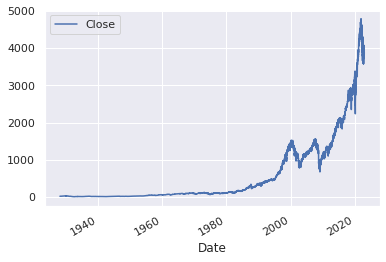

In [113]:
sp500.plot.line(y="Close", use_index=True)

In [114]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [115]:
#make tomorrow column
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500

,Open,High,Low,Close,Volume,Tomorrow
Date,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.760000
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,17.719999
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,17.549999
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,17.660000
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.500000
...,...,...,...,...,...,...
2023-01-03 00:00:00-05:00,3853.290039,3878.459961,3794.330078,3824.139893,3959140000,3852.969971
2023-01-04 00:00:00-05:00,3840.360107,3873.159912,3815.770020,3852.969971,4414080000,3808.100098
2023-01-05 00:00:00-05:00,3839.739990,3839.739990,3802.419922,3808.100098,3893450000,3895.080078


In [116]:
#target for ML
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.760000,1
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,17.719999,0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,17.549999,0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,17.660000,1
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.500000,0
...,...,...,...,...,...,...,...
2023-01-03 00:00:00-05:00,3853.290039,3878.459961,3794.330078,3824.139893,3959140000,3852.969971,1
2023-01-04 00:00:00-05:00,3840.360107,3873.159912,3815.770020,3852.969971,4414080000,3808.100098,0
2023-01-05 00:00:00-05:00,3839.739990,3839.739990,3802.419922,3808.100098,3893450000,3895.080078,1


In [117]:
#remove data before 1990
sp500 = sp500.loc["1990-01-01":].copy()
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...
2023-01-03 00:00:00-05:00,3853.290039,3878.459961,3794.330078,3824.139893,3959140000,3852.969971,1
2023-01-04 00:00:00-05:00,3840.360107,3873.159912,3815.770020,3852.969971,4414080000,3808.100098,0
2023-01-05 00:00:00-05:00,3839.739990,3839.739990,3802.419922,3808.100098,3893450000,3895.080078,1


In [118]:
#train model
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)
train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close","Volume","Open","High","Low"]
model.fit(train[predictors],train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [119]:
#measure how accurate model is
#how accurate is when market(target) go up data go up too
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])

In [120]:
preds = pd.Series(preds, index=test.index)

In [121]:
#how accurate it is
precision_score(test["Target"],preds)

0.3472222222222222

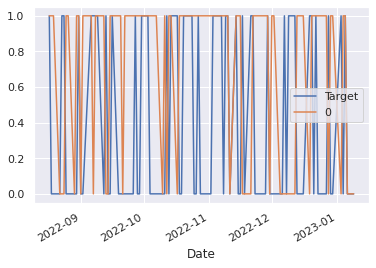

In [122]:
#see how accurate in graph
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [123]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [124]:
#train first model with first 10year for 11 and so on
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [125]:
predictions = backtest(sp500, model, predictors)

In [126]:
#see how many time model predict go up and now
predictions["Predictions"].value_counts()

0    3389
1    2431
Name: Predictions, dtype: int64

In [127]:
#how accurate now
precision_score(predictions["Target"], predictions["Predictions"])


0.5277663512957631

In [128]:
#how many % up or down
predictions["Target"].value_counts() / predictions.shape[0]

1    0.533849
0    0.466151
Name: Target, dtype: float64

In [129]:
#calculate the mean close price in 2days 5 days 60 days 250 days 1000days
#and find ratio bettween today closing price and these periods
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    new_predictors += [ratio_column, trend_column]
    

In [ ]:
sp500

In [131]:
sp500 = sp500.dropna()

In [132]:
#new model
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [133]:
#return probability
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [134]:
predictions = backtest(sp500, model, new_predictors)

In [135]:
predictions["Predictions"].value_counts()

0.0    4006
1.0     813
Name: Predictions, dtype: int64

In [136]:
#accuracy
precision_score(predictions["Target"], predictions["Predictions"])

0.5694956949569495

In [137]:
#Last note it can be a lot more accurate

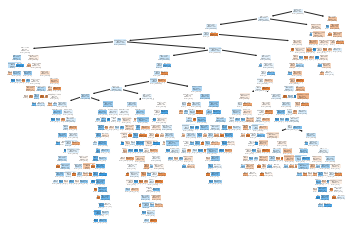

In [151]:
from sklearn.tree import export_graphviz
from matplotlib.pyplot import plot
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
import seaborn as sns; sns.set()
import os
from sklearn.metrics import confusion_matrix

combined = pd.DataFrame(dict(actual=test["Target"], predicted=preds))
pd.crosstab(index=combined["actual"], columns=combined["predicted"])
len(model.estimators_)
model.estimators_[0].tree_.max_depth
_ = tree.plot_tree(model.estimators_[0], feature_names=sp500.columns, filled=True)
